<b> Problem Explained </b>
On the first part of this exercise we have prepared the data that we accquired from the Common Crawl archives using the Amazon Computing Systems, and you can check the whole process <a href="https://github.com/ffmc/data-analytics-portfolio/blob/master/Smartphone%20Sentiment%20Analysis/Smartphone%20Sentiment%20Analysis.ipynb"> here. </a>.
Now on this second part, we will be using that same data, to predict the sentiment towards five different phone ans its IOS to understand which one people like the most. 

We will start by setting up a parallel processing due to the data's large size, explore the data, pre process it and execute feature selection if needed, develop models and its evaluation, feature engineering, apply the model and analyse its results. 

In [ ]:
#Open the necessary libraries
library(readr)
library(caret)
library(plotly)
library(corrplot)
library(doParallel)
library(dplyr)
library(plotly)
library("IRdisplay")

In [ ]:
#Setting up Parallel processing

# Required
library(doParallel)

# Find how many cores are on your machine
detectCores() # Result = Typically 4 to 6

# Create Cluster with desired number of cores. Don't use them all! Your computer is running other processes. 
cl <- makeCluster(2)

# Register Cluster
registerDoParallel(cl)

# Confirm how many cores are now "assigned" to R and RStudio
getDoParWorkers() # Result 2 

Let's now upload the data into our workspace. We will start with the iphone matrix and check it's strutcture. 

In [9]:
#uploading a small matrix for training
iphone_small <- read.csv("iphone_smallmatrix_labeled_8d.csv")
head(iphone_small)
str(iphone_small)

iphone,samsunggalaxy,sonyxperia,nokialumina,htcphone,ios,googleandroid,iphonecampos,samsungcampos,sonycampos,...,sonyperunc,nokiaperunc,htcperunc,iosperpos,googleperpos,iosperneg,googleperneg,iosperunc,googleperunc,iphonesentiment
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,0,0,0,0,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4


'data.frame':	12973 obs. of  59 variables:
 $ iphone         : int  1 1 1 1 1 41 1 1 1 1 ...
 $ samsunggalaxy  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokialumina    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcphone       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ios            : int  0 0 0 0 0 6 0 0 0 0 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 0 0 0 1 1 0 0 0 ...
 $ samsungcampos  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycampos     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacampos    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamneg   : int  0 0 0 0 0 3 1 0 0 0 ...
 $ samsungcamneg  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamneg     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacamneg    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamneg      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 7 1 0 0 0 ...
 $ samsungcamunc  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamunc     : int  

Let's create an histogram to inspect what's the sentiment towards the iPhone on the trainning data.

In [25]:
#Checking for missing data
sum(is.na(iphone_small))

[1] 0

Now lets proceed to the feature selection using a few different methods.
First, the Near Zero Variance that will indicate the variables that have a constant variance and therefore will not add musch to our model our our analysis. 

In [26]:
nzv <- nearZeroVar(iphone_small, saveMetrics = FALSE) 
iphoneNZV <- iphone_small[,-nzv]
str(iphoneNZV)

'data.frame':	12973 obs. of  12 variables:
 $ iphone         : int  1 1 1 1 1 41 1 1 1 1 ...
 $ samsunggalaxy  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcphone       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 0 0 0 1 1 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 7 1 0 0 0 ...
 $ iphonedispos   : int  0 0 0 0 0 1 13 0 0 0 ...
 $ iphonedisneg   : int  0 0 0 0 0 3 10 0 0 0 ...
 $ iphonedisunc   : int  0 0 0 0 0 4 9 0 0 0 ...
 $ iphoneperpos   : int  0 1 0 1 1 0 5 3 0 0 ...
 $ iphoneperneg   : int  0 0 0 0 0 0 4 1 0 0 ...
 $ iphoneperunc   : int  0 0 0 1 0 0 5 0 0 0 ...
 $ iphonesentiment: int  0 0 0 0 0 4 4 0 0 0 ...


This has reduce greatly the size of our matrix from 59 to 12 variables. 

Now we can also proceed to the Recursive Feature Elemination (RFE). Caret’s rfe() function with random forest will try every combination of feature subsets and return a final list of recommended features.

In [ ]:
#Let's sample the data before using RFE
set.seed(123)
iphoneSample <- iphone_small[sample(1:nrow(iphone_small), 1000, replace=FALSE),]

#Set up rfeControl with randomforest, repeated cross validation and no updates
ctrl <- rfeControl(functions = rfFuncs, 
                   method = "repeatedcv",
                   repeats = 5,
                   verbose = FALSE)

#Use rfe and omit the response variable (attribute 59 iphonesentiment) 
rfeResults <- rfe(iphoneSample[,1:58], 
                  iphoneSample$iphonesentiment, 
                  sizes=(1:58), 
                  rfeControl=ctrl)

#Get results
rfeResults


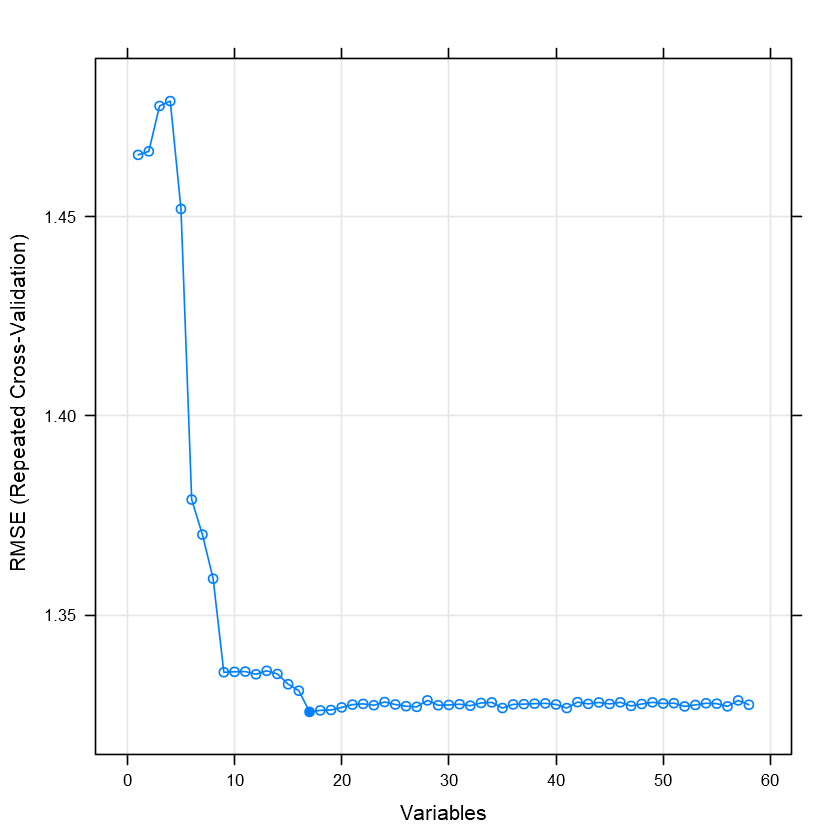

In [28]:
#Plot results
plot(rfeResults, type=c("g", "o"))

In [35]:
# create new data set with rfe recommended features
iphoneRFE <- iphone_small[,predictors(rfeResults)]

#add the dependent variable to iphoneRFE
iphoneRFE$iphonesentiment <- iphone_small$iphonesentiment

# review outcome
str(iphoneRFE)

'data.frame':	12973 obs. of  18 variables:
 $ iphone         : int  1 1 1 1 1 41 1 1 1 1 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonedispos   : int  0 0 0 0 0 1 13 0 0 0 ...
 $ iphonedisneg   : int  0 0 0 0 0 3 10 0 0 0 ...
 $ samsunggalaxy  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcphone       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonedisunc   : int  0 0 0 0 0 4 9 0 0 0 ...
 $ iphoneperpos   : int  0 1 0 1 1 0 5 3 0 0 ...
 $ ios            : int  0 0 0 0 0 6 0 0 0 0 ...
 $ iphoneperneg   : int  0 0 0 0 0 0 4 1 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphoneperunc   : int  0 0 0 1 0 0 5 0 0 0 ...
 $ iphonecampos   : int  0 0 0 0 0 1 1 0 0 0 ...
 $ iphonecamneg   : int  0 0 0 0 0 3 1 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 7 1 0 0 0 ...
 $ htcdisunc      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonesentiment: int  0 0 0 0 0 4 4 0 0 0 ...


In [38]:
#Finding the highly correlated variables
correlationMatrix <- cor(iphone_small[,1:59])
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff=0.85)
print(highlyCorrelated)

 [1] 29 24 56 54 34 21 31 26 41 11 36 46 28 33 57 55 30  6  5


In [39]:
#Removing the highly correlated variables
iphoneCOR <- iphone_small[-c(29,24, 56, 54, 34, 21, 31, 26, 41, 11, 36, 46, 28, 33, 57, 55, 30,  6,  5)]

In [40]:
str(iphoneCOR)

'data.frame':	12973 obs. of  40 variables:
 $ iphone         : int  1 1 1 1 1 41 1 1 1 1 ...
 $ samsunggalaxy  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokialumina    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 0 0 0 1 1 0 0 0 ...
 $ samsungcampos  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycampos     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamneg   : int  0 0 0 0 0 3 1 0 0 0 ...
 $ samsungcamneg  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamneg     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacamneg    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamneg      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 7 1 0 0 0 ...
 $ samsungcamunc  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamunc     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamunc      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonedispos   : int  0 0 0 0 0 1 13 0 0 0 ...
 $ sonydispos     : int 

We are going also to create another matrix by agrupping the levels of positive and negative sentiment. At the moment the matrix iphone_small has 6 levels of sentiment, and we will reduce it to only 4: 1: negative, 2: somewhat negative, 3: somewhat positive, 4: positive. 

In [63]:
# create a new dataset that will be used for recoding sentiment
iphoneRC <- iphone_small
# recode sentiment to combine factor levels 0 & 1 and 4 & 5
iphoneRC$iphonesentiment <- recode(iphoneRC$iphonesentiment, '0' = 1, '1' = 1, '2' = 2, '3' = 3, '4' = 4, '5' = 4) 


So now that we have 5 daframes we will proceed to the model creation that will be applied to said dataframes: iphone_small, iphoneNZV, iphoneRFE and iphoneCOR.
We will be trainning 4 models, KNN and SVM, C5.0 and Random Forest. 

In [64]:
##Convert the dependent variable to factor 
iphone_small$iphonesentiment <- as.factor(iphone_small$iphonesentiment)
iphoneNZV$iphonesentiment <- as.factor(iphoneNZV$iphonesentiment)
iphoneRFE$iphonesentiment <- as.factor(iphoneRFE$iphonesentiment)
iphoneCOR$iphonesentiment <- as.factor(iphoneCOR$iphonesentiment)
iphoneRC$iphonesentiment <- as.factor(iphoneRC$iphonesentiment)

Model Training

In [42]:
#10 fold cross validation
fitControl <- trainControl(method = "cv", number = 10)

In [57]:
# define an 70%/30% train/test split of the small matrix
inT_iphone_small <- createDataPartition(iphone_small$iphonesentiment, p = .70, list = FALSE)

iphone_s_tr <- iphone_small[inT_iphone_small, ]
iphone_s_te <- iphone_small[-inT_iphone_small, ]

In [58]:
#train C5.0 model 
iphoneSmall_C5.0 <- train(iphonesentiment~., data = iphone_s_tr, method = "C5.0", trControl=fitControl)
#prediction 
iphoneSmall_C5.0_pred <- predict(iphoneSmall_C5.0, iphone_s_te)

In [ ]:
#random forest
iphoneSmall_RF <- train(iphonesentiment~., data = iphone_s_tr, method = "rf", 
                        trControl=fitControl)
#prediction 
iphoneSmall_RF_pred <- predict(iphoneSmall_RF, iphone_s_te)

In [ ]:
#SVM
iphoneSmall_SVM <- train(iphonesentiment~., data = iphone_s_tr, 
                        method = "svmLinear2", trControl = fitControl)
#prediction 
iphoneSmall_SVM_pred <- predict(iphoneSmall_SVM, iphone_s_te)

In [ ]:
#KNN
iphoneSmall_KNN <- train(iphonesentiment~., data = iphone_s_tr, 
                        method = "kknn", trControl = fitControl)
#prediction 
iphoneSmall_KNN_pred <- predict(iphoneSmall_SVM, iphone_s_te)

In [ ]:
We also applied the same models to the remaining matrixes and proceeded to its evaluation.

#evaluate C5.0
postResample(iphoneSmall_C5.0_pred, iphone_s_te$iphonesentiment)
#evaluate random forest
postResample(iphoneSmall_RF_pred, iphone_s_te$iphonesentiment)
#evaluate SVM
postResample(iphoneSmall_SVM_pred, iphone_s_te$iphonesentiment)
#evaluate KKNN
postResample(iphoneSmall_KNN_pred, iphone_s_te$iphonesentiment)

In [ ]:
With the results we created the following graph, to better understand which model had the best performance. 

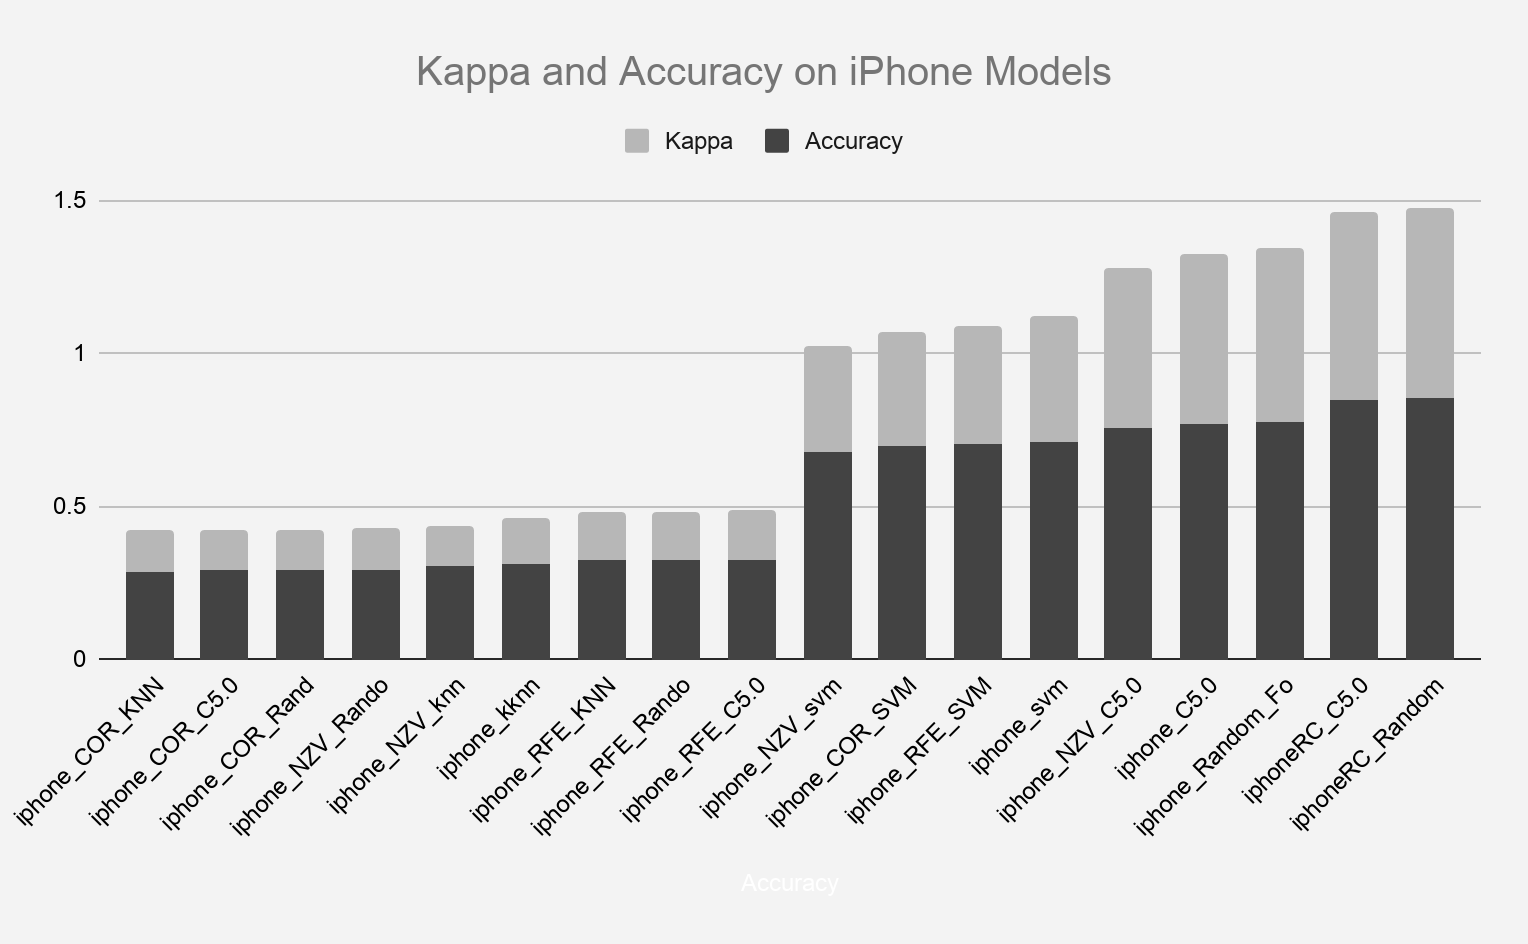

In [61]:
display_png(file="C:/Users/Francisco Cardoso/Documents/UT Data Analytics/Github/C4.T3/Kappa_Accuracy_iPhone.png")

As we can see on the graph above, the best performing models were Random Forest and C5.0 and when applied to the iphoneRC matrix. 

We have repeated exactly the same process to the Galaxy dataframe and obtaoned the following results. 

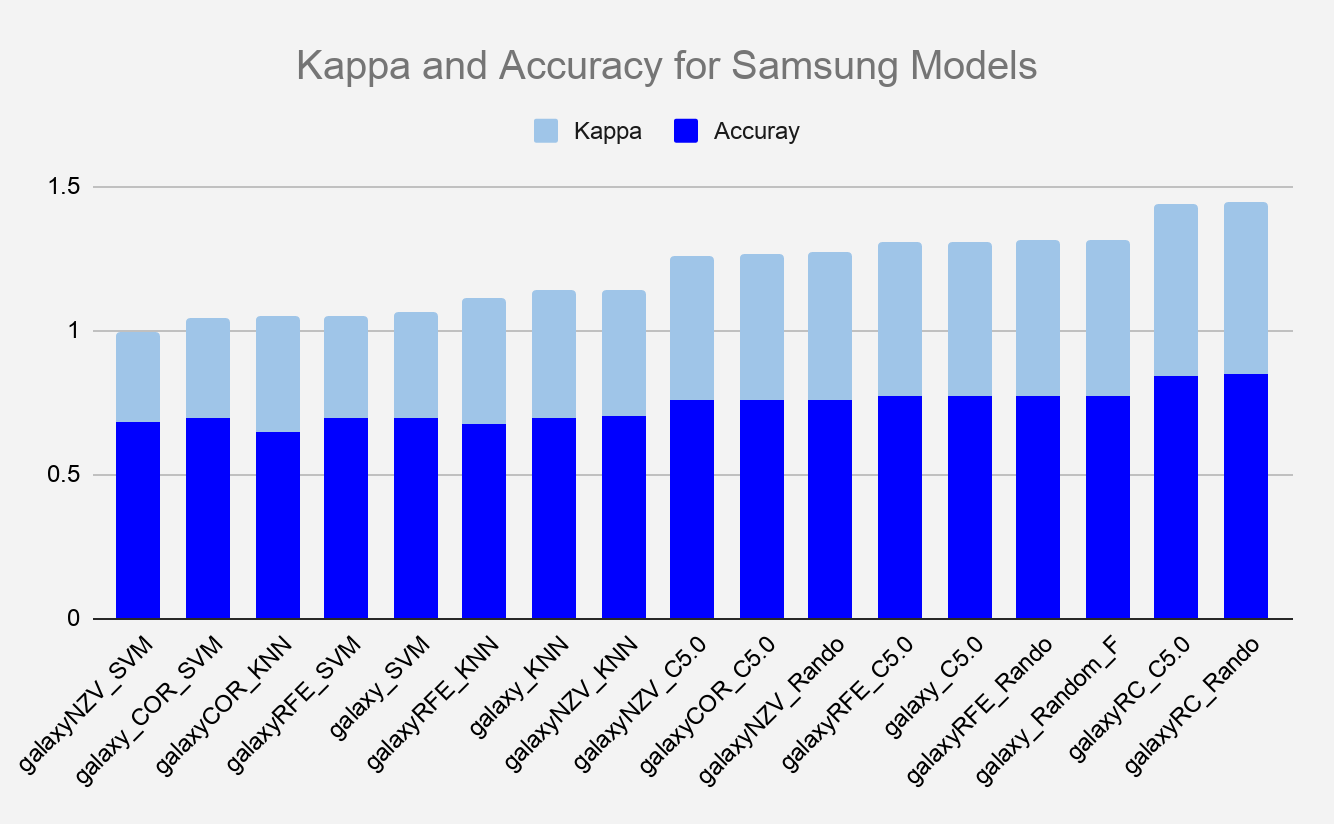

In [67]:
display_png(file="C:/Users/Francisco Cardoso/Documents/UT Data Analytics/Github/C4.T3/Kappa_Accuracy_Galaxy.png")

As we can see, the better performing models were the same and also on the same dataframe, our winners are Random Forest and C5.0 on galaxyRC. 

Now that we have our best models we can now create the predictions that we have created with our galaxyRC_RF and iphoneRC_RF.  

In [ ]:
# upload the large matrix, delete id column
iphoneLarge <- read_csv("LargeMatrix copy.csv")
iphoneLarge$id <- NULL

# make the prediction for iphone 
iphoneLarge_pred <- predict(iphoneC5.0_RC, iphoneLarge)

#And also the same for the Galaxy
galaxylargeMatrix <- read_csv("LargeMatrix copy.csv")
galaxylargeMatrix_pred <- predict(galaxyC5.0_RC, galaxylarge)

We can now analyse the sentiment towards Galaxy and iPhone. 

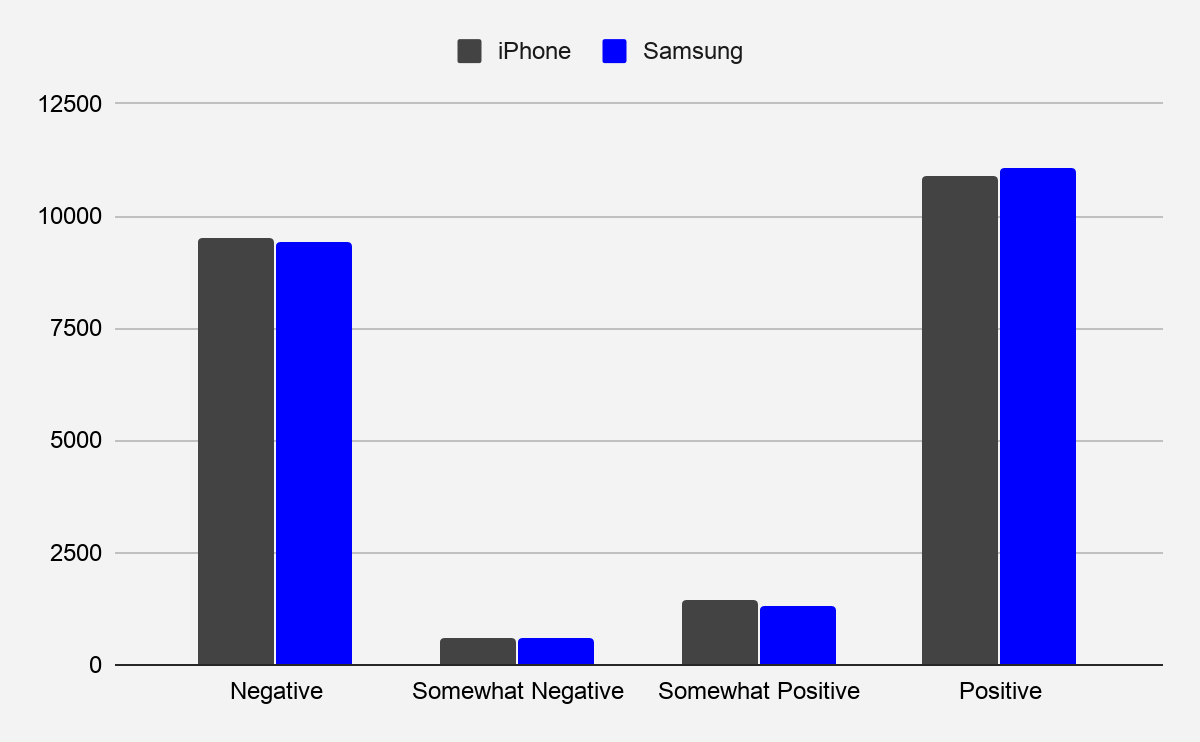

In [69]:
display_png(file="C:/Users/Francisco Cardoso/Documents/UT Data Analytics/Github/C4.T3/sentiment both.png")

As we can see the results are very similar and we can draw two big conclusions here:

1 - People have very strong opinions towards one or another, only a very small amount (9%) of words reveal a mild opinion towards one or another
2 - People who like Samsung will very likely dislike iPhone and other way around, the attachment to one or another is very strong. 